In [14]:
import nibabel as nib
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.measure import label, regionprops
from matplotlib.patches import Rectangle
from scipy.ndimage import binary_erosion, label

# Load the CT scan
ct_file_path = "C:\\Users\\alelj\\OneDrive\\Desktop\\amsterdam\\AI for medical imaging\\ai4mi_project\\data\\segthor_train\\train\\Patient_01\\Patient_01.nii.gz"
ct_image = nib.load(ct_file_path)
ct_data = ct_image.get_fdata()

# Load the ground truth segmentation
gt_file_path = "C:\\Users\\alelj\\OneDrive\\Desktop\\amsterdam\\AI for medical imaging\\ai4mi_project\\data\\segthor_train\\train\\Patient_01\\GT.nii.gz"
gt_image = nib.load(gt_file_path)
gt_data = gt_image.get_fdata()


In [15]:
# Get voxel dimensions (pixel spacing)
dx, dy, dz = ct_image.header.get_zooms()


In [16]:
# Calculate Transverse Diameters of Heart

num_slices = ct_data.shape[2]
heart_diameters = np.zeros(num_slices)

for slice_number in range(num_slices):
    # Heart segmentation for the current slice
    heart_slice = gt_data[:, :, slice_number]
    heart_mask = (heart_slice == 2)  # Heart label is 2

    # Calculate heart transverse diameter if heart is present in the slice
    if np.any(heart_mask):
        x_indices = np.where(np.any(heart_mask, axis=1))[0]
        if x_indices.size > 0:
            left_heart = x_indices.min()
            right_heart = x_indices.max()
            heart_diameter = (right_heart - left_heart + 1) * dx
            heart_diameters[slice_number] = heart_diameter

# Identify the slice with the maximum heart diameter
max_heart_slice = np.argmax(heart_diameters)
max_heart_diameter = heart_diameters[max_heart_slice]
print(f"Slice with maximum heart diameter: {max_heart_slice}")
print(f"Maximum heart diameter: {max_heart_diameter:.2f} mm")

Slice with maximum heart diameter: 79
Maximum heart diameter: 130.86 mm


In [17]:
# Select the slice with the maximum heart diameter
slice_number = max_heart_slice

# Extract the CT slice
ct_slice = ct_data[:, :, slice_number]

# Thresholding to segment the body
body_threshold = -300  # Threshold to separate body from air
body_mask = ct_slice > body_threshold

# Remove small objects and keep the largest connected component
body_mask = morphology.remove_small_objects(body_mask.astype(bool), min_size=500)
labeled_mask = measure.label(body_mask)
regions = measure.regionprops(labeled_mask)

if regions:
    # Assuming the largest area is the thorax
    body_region = max(regions, key=lambda x: x.area)
    body_mask = labeled_mask == body_region.label

# Inside the body mask, select pixels with HU above 800 (bones)
bone_threshold = 800
bone_mask = (ct_slice > bone_threshold) & body_mask

# Initialize variables
dx = ct_image.header.get_zooms()[0]  # Pixel spacing in x-direction
max_width = 0
left_edge = right_edge = 0

# Iterate over each row (y-coordinate) within the body mask
y_indices = np.where(np.any(bone_mask, axis=0))[0]

for y in y_indices:
    # Extract the row from the bone mask
    row = bone_mask[:, y]
    x_indices = np.where(row)[0]
    if x_indices.size > 0:
        width = (x_indices[-1] - x_indices[0] + 1) * dx
        if width > max_width:
            max_width = width
            left_edge = x_indices[0]
            right_edge = x_indices[-1]
            y_coordinate = y  # Save the y-coordinate where max width was found

if max_width > 0:
    thoracic_diameter = max_width
    print(f"Thoracic diameter (bones within body mask) on slice {slice_number}: {thoracic_diameter:.2f} mm")
    print(f"Measured at y-coordinate: {y_coordinate}")
else:
    print("Unable to determine thoracic diameter from bone mask.")


Thoracic diameter (bones within body mask) on slice 79: 47.85 mm
Measured at y-coordinate: 341


In [18]:
# Ensure both diameters are available
if max_heart_diameter > 0 and thoracic_diameter > 0:
    # Calculate the cardiothoracic ratio
    ctr = max_heart_diameter / thoracic_diameter
    print(f"Cardiothoracic ratio (CTR): {ctr:.2f}")

    # Determine if CTR is higher than 0.5
    is_cardiomegaly = ctr > 0.5
    print(f"Is cardiomegaly present (CTR > 0.5)? {is_cardiomegaly}")
else:
    print("Unable to calculate CTR due to missing diameters.")



Cardiothoracic ratio (CTR): 2.73
Is cardiomegaly present (CTR > 0.5)? True


C:\Users\alelj\AppData\Local\Temp\ipykernel_11776\1496523409.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(heart_mask.T, colors='red', linewidths=1, label='Heart Mask')


NameError: name 'inner_edges_mask' is not defined

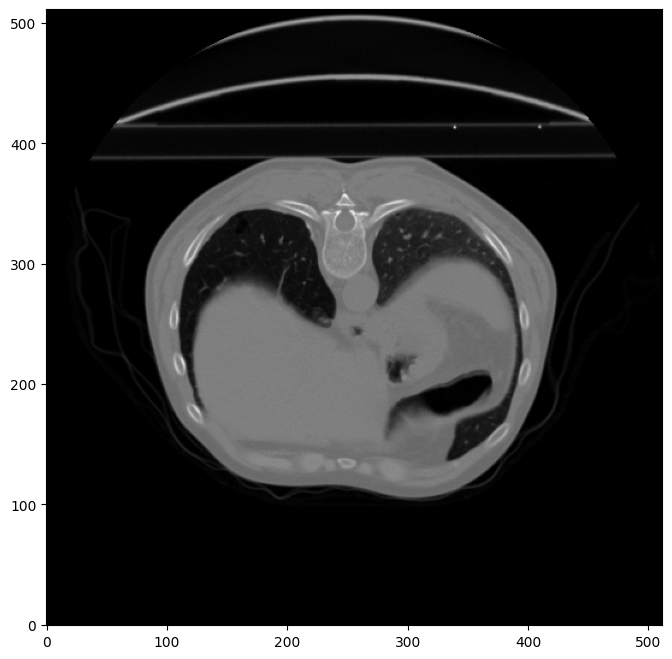

In [19]:
# Visualize the Segmentation of the Thorax with Inner Diameter

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(ct_slice.T, cmap='gray', origin='lower')

# Overlay the heart mask
ax.contour(heart_mask.T, colors='red', linewidths=1, label='Heart Mask')

# Overlay the inner edges of the thoracic cavity
ax.contour(inner_edges_mask.T, colors='blue', linewidths=1, label='Inner Thoracic Edges')

# Draw heart diameter line
ax.plot([left_heart, right_heart], [ct_slice.shape[1]//2, ct_slice.shape[1]//2],
        color='yellow', linewidth=2, label='Heart Diameter')

# Draw thoracic diameter line
ax.plot([left_inner_edge, right_inner_edge], [ct_slice.shape[1]//2, ct_slice.shape[1]//2],
        color='cyan', linewidth=2, label='Thoracic Diameter (Inner Edges)')

# Add legend and labels
ax.set_title(f'Slice {slice_number} - Heart and Thoracic Diameters')
ax.set_xlabel('X-axis (pixels)')
ax.set_ylabel('Y-axis (pixels)')
ax.legend(loc='upper right')

plt.show()

